# Kernel Shape Example
Spring 2019 AME-70790 Final Project

Nicholas Geneva (ngeneva@nd.edu)

Reference: Wand, M. P., & Jones, M. C. (1994). Kernel smoothing. Chapman and Hall/CRC.
___
In the previous example we looked at how the bandwidth of a kernel in significantly influence the kernel smoother prediction.
Now let us look at the impact of the shape of the kernel function $K$.
Again consider this arbitrary density:
    $$f_{1}(x)=\frac{3}{4}\phi\left(x | 0,1\right) + \frac{1}{4}\phi\left(x | 3/2, 1/3\right),$$
where $\phi(x)$ is the normal PDF making this a mixture of two Gaussians. We will use 1000 training data points to approximate this density function with the kernel density estimator.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
np.random.seed(123)
ntrain = 1000
l = 0.25 # band width

# Target data
x_test = np.linspace(-3,3,200)
y_test = 0.75*norm.pdf(x_test, loc=0, scale=1) + 0.75*norm.pdf(x_test, loc=3/2, scale=1/3)
# Training data
c1 = np.sum(np.random.rand(ntrain) < 0.75)
c2 = ntrain - c1
x_train0 = np.concatenate([np.random.randn(c1), (1/3.)*np.random.randn(c1)+1.5], axis=0)

Here we will consider three different kernels. 
For kernels to be comparable, three constraints are imposed:
    $$\int K(x)dx = 1, \quad \int xK(x)dx=0, \quad \int x^{2}K(x)dx=a^{2}<\infty,$$
which impose normalization, symmetry and the variance respectively.
Although kernel symmetry is not required, symmetric kernels are commonly used since they are easier to interpret.
Its important to note that the variance is **not** always the bandwidth.
To illustrate this point and the impact of kernel shape on the KDE prediction, we will compare kernels using the same *bandwidth* and also the same *standard deviation* (a=h).

The first will be the standard Gaussian kernel we used in the previous example:
    $$f(x,h)=(nh)^{-1}\sum_{i=1}^{n}K\left(\frac{x-x_{i}}{h}\right), \quad K(x)=\frac{1}{\sqrt{2\pi} a}\exp\left\{\frac{-x^{2}}{2 a^{2}}\right\},$$
where $a$ is the standard deviation.
The normal kernel is unique in the sense that the bandwidth and standard deviation are the interchangeable.

In [3]:
# Set-up prediction points
x_pred0 = np.linspace(-3, 3, 500)
# Expand array dims and repeat
x_pred = np.expand_dims(x_pred0, axis=1).repeat(x_train0.shape[0], axis=1)
x_train = np.expand_dims(x_train0, axis=0).repeat(x_pred0.shape[0], axis=0)
x0 = x_pred-x_train

normal_pred = []
normal_mass = []

# Compute normal kernel using set bandwidth
x0_scaled = x0/l
y_pred0 = (1/(ntrain*l))*np.sum(norm.pdf(x0_scaled), axis=1)
normal_pred.append(y_pred0)

# Compute normal kernel using set variance
y_pred0 = (1/ntrain)*np.sum(norm.pdf(x0, scale=l), axis=1)
normal_pred.append(y_pred0)

normal_mass.append(norm.pdf(x_pred0/l))
normal_mass.append(norm.pdf(x_pred0, scale=l))

For the second kernel we will use the *Epanechnikov kernel*, which is given by:
    $$K(x)=\frac{3}{4}\left[\frac{1-x^{2}/(5a^{2})}{a\sqrt{5}}\right]\mathbf{1}_{|x|<a\sqrt{5}},$$
where $\mathbf{1}_{A}$ is the indicator function and $a$ is its scale or bandwidth parameter.
The most commonly used standard deviation is $a^2=1/5$ as this clearly simplifies the kernel.
This kernel is particularly unique in the sense that there are theoretical arguments that this is actually the optimal kernel based on data efficiency, although the Gaussian is more frequently used.
Additionally, we note that both the Gaussian kernel and Epanechnikov kernel are derived from the same family:
    $$K(x,p)=\left[2^{2p+1}B(p+1,p+1)\right]^{-1}\left(1-x^{2}\right)^{p}\mathbf{1}_{|x|<1},$$
where $B(a,b)$ is the beta function.
The Gaussian kernel and Epanechnikov kernel can be recovered when $p\rightarrow \infty$ and $p=1$ respectively.
Additional kernels in this family include the Bi-weight and Tri-weight which are when $p=2$ and $p=3$ respectively.

In [4]:
epan_pred = []
epan_mass = []

# Compute Epanechnikov kernel using set bandwidth (a^2 = 1/5)
x0_scaled = x0/l
y_pred0 = (1/(ntrain*l))*np.sum(0.75*(1-x0_scaled**2)*(np.abs(x0_scaled) < 1), axis=1)
epan_pred.append(y_pred0)

# Compute Epanechnikov kernel using set variance
y_pred0 = (1/ntrain)*np.sum(0.75*((1-x0**2/(5*l**2))/(l*np.sqrt(5)))*(np.abs(x0) < l*np.sqrt(5)), axis=1)
epan_pred.append(y_pred0)

epan_mass.append(0.75*(1-(x_pred0/l)**2)*(np.abs(x_pred0/l) < 1))
epan_mass.append(0.75*((1-x_pred0**2/(5*l**2))/(l*np.sqrt(5)))*(np.abs(x_pred0) < l*np.sqrt(5)))

The third kernel we will consider is the triangular kernel which is defined as:
    $$K(x)=\frac{1}{a\sqrt{6}}\left(1-\frac{|x|}{a\sqrt{6}}\right)\mathbf{1}_{|x|<a\sqrt{6}}.$$
Similar to the Epanechnikov kernel the most commonly used standard deviation is $a^2 = 1/6$ due to the obvious simplifications.
These and other kernels can be reference on [Wikipedia](https://en.wikipedia.org/wiki/Kernel_%28statistics%29). 

In [5]:
tri_pred = []
tri_mass = []

# Compute Triangular kernel using set bandwidth (a^2 = 1/6)
x0_scaled = x0/l
y_pred0 = (1/(ntrain*l))*np.sum((1-np.abs(x0_scaled)) * (np.abs(x0_scaled) < 1), axis=1)
tri_pred.append(y_pred0)

# Compute Triangular kernel using set variance
h = l*np.sqrt(6)
y_pred0 = (1/ntrain)*np.sum((1-np.abs(x0)/h)/h * (np.abs(x0) < h), axis=1)
tri_pred.append(y_pred0)

tri_mass.append((1-np.abs(x_pred0/l)) * (np.abs(x_pred0/l) < 1))
tri_mass.append((1-np.abs(x_pred0)/h)/h * (np.abs(x_pred0) < h))

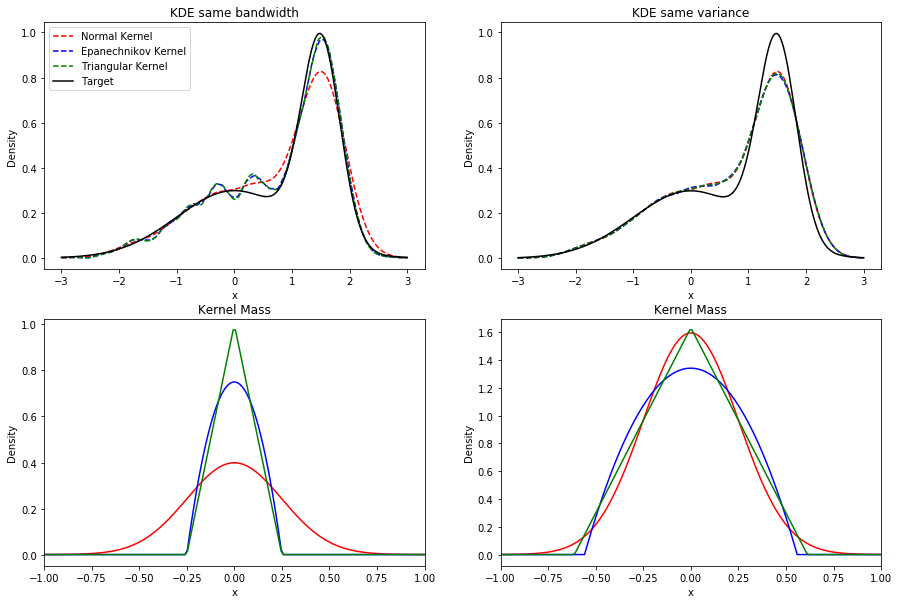

In [7]:
plt.close("all")
fig = plt.figure(figsize=(15,10))
ax = []
ax.append(plt.subplot2grid((2, 2), (0, 0)))
ax.append(plt.subplot2grid((2, 2), (0, 1)))
ax.append(plt.subplot2grid((2, 2), (1, 0)))
ax.append(plt.subplot2grid((2, 2), (1, 1)))

for i in range(2):
    # Normal prediction
    ax[i].plot(x_pred0, normal_pred[i], '--', c='r', label='Normal Kernel')
    # Epanechnikov prediction
    ax[i].plot(x_pred0, epan_pred[i], '--', c='b', label='Epanechnikov Kernel')
    # Triangular prediction
    ax[i].plot(x_pred0, tri_pred[i], '--', c='g', label='Triangular Kernel')
    # Target density
    ax[i].plot(x_test, y_test, c='k', label='Target')
    
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('Density')
    
    # Kernel Mass
    ax[i + 2].plot(x_pred0, normal_mass[i], c='r')
    ax[i + 2].plot(x_pred0, epan_mass[i], c='b')
    ax[i + 2].plot(x_pred0, tri_mass[i], c='g')
    ax[i + 2].set_xlim([-1,1])
    ax[i + 2].set_title('Kernel Mass')
    ax[i + 2].set_xlabel('x')
    ax[i + 2].set_ylabel('Density')
    
ax[0].set_title('KDE same bandwidth')
ax[1].set_title('KDE same variance')

ax[0].legend(loc=2)    
plt.show()

(Left to right) The KDE using kernels with the same bandwidth but different variance and the KDE using kernels with the same variance. (Top to bottom) The KDE and the kernel mass. We can see that when the kernels have roughly the shape (or standard deviation) the KDE is approximately the same. Thus bandwidth **and** kernel shape have strong influence over the density estimates.